 # Packages Loading and config

In [1]:
import sys
import logging
import pickle

import tomli
import pandas as pd

from pytanis import GSheetsClient, PretalxClient
from pytanis.pretalx import subs_as_df
from pytanis.review import Col
import pytanis

from helpers import (
    setup_plotting, load_track_mapping, load_column_mapping,
    build_reviews_df, prepare_submissions, prepare_reviewers, validate_mappings,
    plot_reviews_per_proposal, plot_progress, plot_reviewer_stats,
    assign_proposals, add_all_proposals_reviewers, save_assignments,
)

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

setup_plotting()
logging.basicConfig(level=logging.WARNING, stream=sys.stdout)

In [2]:
pytanis.__version__

'0.9.6'

In [3]:
with open("../config.toml", "rb") as fh:
    cfg = tomli.load(fh)

TARGET_REVIEWS = 3
BUFFER_REVIEWS = 6
COMMUNITY_MAP = (
    "General: Community, Diversity, Career, Life and everything else",
    "General: Community",
)

TRACK_MAPPING, PREF_ALIASES = load_track_mapping()
COL_MAPPING = load_column_mapping()

 # Read Reviews and all Submissions
 ## Connect to pretalx and pull the latest submissions and reviewys

In [4]:
pretalx = PretalxClient(blocking=True)
_, subs = pretalx.submissions(cfg["event_name"])
_, revs = pretalx.reviews(cfg["event_name"])
subs, revs = list(subs), list(revs)

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/1493 [00:00<?, ?it/s]

### Optional (save the submissions locally)

In [5]:
with open("./submission_state_2025-01-28.pkl", "wb") as fh:
    pickle.dump(subs, fh)

 ## Get Reviews and reviewers

In [6]:
revs_df, revs_counts = build_reviews_df(revs)
revs_user_df = revs_df.groupby(Col.pretalx_user).agg(list).reset_index()
revs_user_df

,Pretalx user,created,updated,score,review
0,Akshay Paliwal,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 3.0, 2.0, 1.0, ...","[3AQVNE, VGVDED, APWGQB, 7Q9XSS, VUHSG9, ZJMRW..."
1,Alex Tello,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[1.0, 0.0, 2.0, 3.0, 2.0, 0.0, 3.0, 2.0, 1.0, ...","[837AFR, MCDPXM, MRL8KM, GPV9SM, PMMEAG, JMTPJ..."
2,Alexander CS Hendorf,"[None, None, None, None, None, None, None, None]","[None, None, None, None, None, None, None, None]","[3.0, 3.0, 1.0, 3.0, 1.0, 1.0, 3.0, 0.0]","[Q9HMT3, CWEWAT, VGVDED, SZYPRV, ETEQGQ, PV9TU..."
3,Alexander Grote,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[2.0, 1.0, 1.0, 3.0, 3.0, 3.0, 2.0, 3.0, 1.0, ...","[39MHWT, RKG9TU, MGD8SJ, LZVKCJ, P7NYXB, B8KVN..."
4,Alexander Seeliger,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[3.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...","[QB7VLW, KFUQS8, MS7AWK, BCCS7R, ML7PVM, XAHPC..."
5,Anastasia Karavdina,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[3.0, 1.0, 3.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, ...","[3BYLZU, MMQ8SX, NDXCXK, WSNBD9, VGVDED, SZYPR..."
6,Andreas Albert,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[3.0, 2.0, 3.0, 1.0, 2.0, 3.0, 2.0, 2.0, 1.0, ...","[YZGLH8, VZK39M, VJPQCR, 7EYMZS, ED7TPT, GATMP..."
7,Andrei Beliankou,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[2.0, 2.0, 1.0, 2.0, 2.0, 3.0, 2.0, 1.0, 1.0, ...","[NN8ZRP, HPGKCN, PRUU7N, LLK7MB, GMNE3E, 3JLSE..."
8,Anette Haferkorn,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 3.0, 2.0, ...","[VN9DT8, 7SXJAP, GFSEL7, MKAKLR, BHJERV, 9VLHK..."
9,Anja Pilz,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[7EYMZS, ZLRFR9, RHJ9RR, G3F8YH, TNMVX7, JJRM9..."


 ## Submissions

In [7]:
subs_df = prepare_submissions(subs_as_df, subs, revs_counts, TARGET_REVIEWS, COMMUNITY_MAP, TRACK_MAPPING)
all_sub_codes = list(subs_df[Col.submission])

 ## Some Statistics about the current Review Process

<Axes: title={'center': 'Review Progress'}>

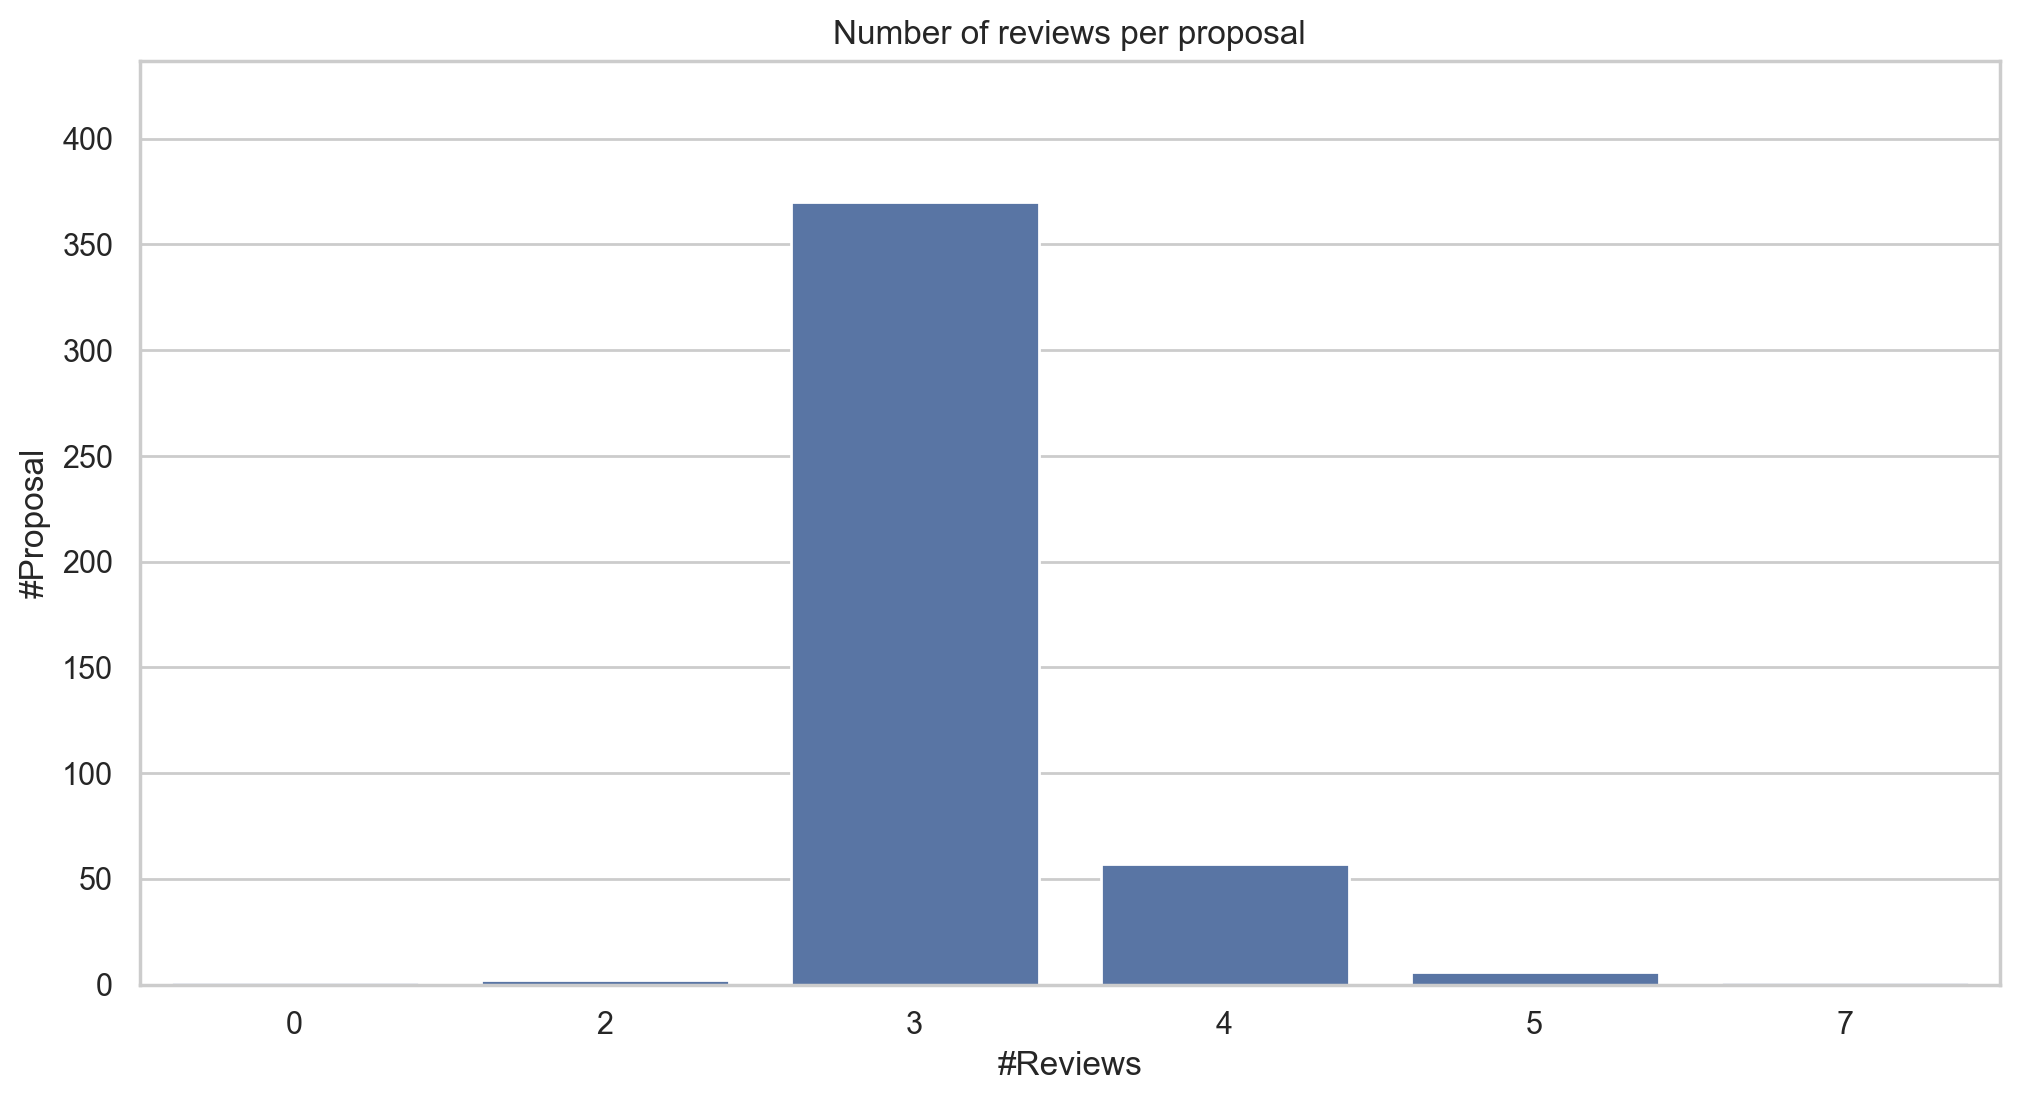

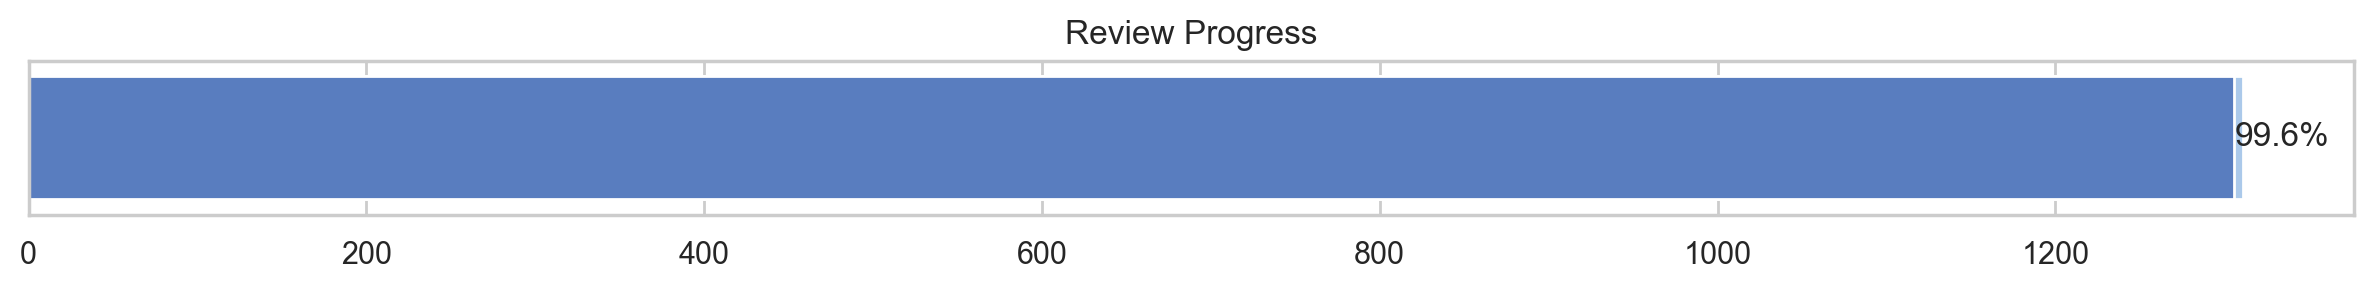

In [8]:
plot_reviews_per_proposal(subs_df)
plot_progress(subs_df, TARGET_REVIEWS)

 # Get spreadsheet with reviewers and preferences

In [9]:

gsheet = GSheetsClient()
gsheet_df = gsheet.gsheet_as_df(cfg["reviewer_spread_id"], cfg["reviewer_work_name"])
validate_mappings(revs_user_df, gsheet_df, COL_MAPPING)


TypeError: validate_mappings() takes 2 positional arguments but 3 were given

In [ ]:
reviewers_df, assign_all_emails = prepare_reviewers(
    gsheet_df, revs_df, COL_MAPPING, COMMUNITY_MAP, PREF_ALIASES
)
reviewers_df.head()

 ### Reviewer Statistics

In [ ]:
plot_reviewer_stats(reviewers_df)

#### Reviewers who reviewed at least 1 submission

In [ ]:
reviewers_df[[Col.speaker_name, Col.done_nreviews]][reviewers_df[Col.done_nreviews] > 0].shape

 ### Check Track Mapping Coverage

In [ ]:
reviewer_prefs = {p for prefs in reviewers_df[Col.track_prefs] for p in prefs}
sub_tracks = set(subs_df[Col.track].dropna())

print("Submission tracks:", sorted(sub_tracks))
print("Reviewer preferences:", sorted(reviewer_prefs))
print("Missing coverage:", sub_tracks - reviewer_prefs)
print("Unused preferences:", reviewer_prefs - sub_tracks)

 # Assign proposals to reviewers

 The main idea is to assign each the number of needed reviews plus a buffer for a proposal/submission:
 * not a person having already assigned the review for a submission (no duplicates)
 * to a person having a preference for the track with the least amount of current work.
 * if no person has a preference for the track of the proposal, assign to someone with not much work.
 (it might be that someone gets by accident assigned his/her own proposal but Pretalx takes care of that if the same user e-mail was used)

 This is done initially. Then whenever this script is rerun, we remove all propoals from the review when the target review number is reached.
 We keep the current state, so that the initial number of proposals for review will only get smaller. From last year we learnt that reviewers
 hate it when we start assigning more and more work... who would have thought.

 Other considerations for the algorithm:
 * Don't have a state, i.e. do not depend on a former assignment json, been there, tried it, always causes trouble in the end
 * Make sure reviewers can visit submissions again which they already reviewed, i.e. make sure you do not remove already reviwed submission from a new assignment.
 * Keep in mind that there are always reviwers that sign up late for the party.

In [ ]:
# Exclude reviewers who requested all proposals from regular assignment
regular_reviewers = reviewers_df[
    ~reviewers_df[Col.all_proposals].apply(
        lambda x: str(x).strip().lower() == "x" if pd.notna(x) else False
    )
]

new_assign_df = assign_proposals(subs_df, regular_reviewers, buffer=BUFFER_REVIEWS)
new_assign_df = add_all_proposals_reviewers(
    new_assign_df, reviewers_df, assign_all_emails, all_sub_codes
)

print(f"Final assignment shape: {new_assign_df.shape}")

In [ ]:
filename = save_assignments(new_assign_df)
print(f"Saved to {filename}")

 # Final reviewing results

In [ ]:
df = new_assign_df[[Col.speaker_name, Col.done_nreviews, "Current #Assignments"]]
df.sort_values(Col.done_nreviews, ascending=False)